In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import braingeneers
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data
import braingeneers.data.datasets_electrophysiology as ephys
import scipy.io as sio
import scipy
from scipy.ndimage import gaussian_filter1d
import glob
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import random

In [2]:
sd = read_phy_files('/home/jovyan/work/Experiment/data/ephys/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_7_curated.zip')

/tmp/ipykernel_1047119/2457172422.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files('/home/jovyan/work/Experiment/data/ephys/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_7_curated.zip')


In [3]:
def plot_raster(sd):
    idces, times = sd.idces_times()
    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()
    
def raster_analysis(sd, seconds=20):
    # Zoomed Raster and pop rate
    # Get coordinates for raster
    idces, times = sd.idces_times()

    # Get population rate for everything
    pop_rate = sd.binned(bin_size=1)# in ms
    # Lets smooth this to make it neater
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float),sigma=sigma) 
    t = np.linspace(0,sd.length,pop_rate.shape[0])/1000

    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax2 = ax.twinx()
    ax2.plot(t,pop_rate_smooth,c='r')

    ax.set_xlim(0,seconds)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')
    plt.show()

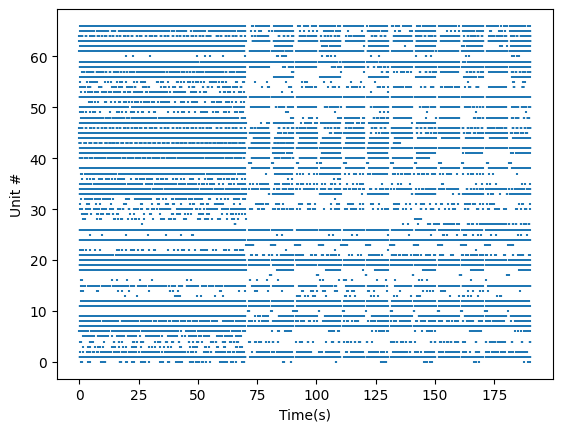

In [4]:
plot_raster(sd)

In [5]:
# sd_start = sd.subtime(0, 10000)

In [6]:
# raster_analysis(sd_start)

In [7]:
# n_data = sd_start.neuron_data

In [8]:
# not_empties = []
# arrays = sd_start.train

# for i, arr in enumerate(arrays):
#     if len(arr) > 0:
#         not_empties.append(i)
        
# print(not_empties)

In [9]:
# empties = []

# for i, arr in enumerate(arrays):
#     if len(arr) == 0:  # Check if the array is empty
#         empties.append(i)  # Add the index to the "empties" list

In [10]:
# sub_start = sd_start.subset(not_empties)

In [11]:
# Given a list of lists representing latencies, calculate the mean latency for each sublist.
# Returns a list containing the mean latencies for each sublist.
def latencies_mean(lat_list):
    nested_list = lat_list
    for i in range(len(nested_list)):
        sublist = nested_list[i]
        length = len(sublist)
        if length == 0:
            sublist_mean = 0
        else:
            sublist_mean = sum(sublist)/len(sublist)
            sublist_mean = round(sublist_mean, 3) # Round to 3d.p.
        nested_list[i] = sublist_mean
    return nested_list

In [12]:
def calculate_mean_latencies(sd):
    num_neurons = sd.N
    latencies_array = [None] * num_neurons

    for curr_neuron in range(num_neurons):
        latencies = latencies_mean(sd.latencies_to_index(curr_neuron))
        latencies_array[curr_neuron] = latencies

    return latencies_array

In [13]:
latencies = calculate_mean_latencies(sd)

In [14]:
def compute_in_out_degree(latencies_array):
    num_neurons = len(latencies_array)
    in_out_deg = [(0, 0) for _ in range(num_neurons)]

    for curr_neuron in range(num_neurons):
        in_deg = 0
        out_deg = 0
        curr_neural_latencies = latencies_array[curr_neuron]

        for i in range(len(curr_neural_latencies)):
            if curr_neural_latencies[i] > 0:
                out_deg += 1
            if curr_neural_latencies[i] < 0:
                in_deg += 1

        in_out_deg[curr_neuron] = (in_deg, out_deg)

    return in_out_deg

In [15]:
in_out_deg = compute_in_out_degree(latencies)

In [16]:
def label_nodes(in_out_deg, frac_threshold=0.05):
    node_info = ['b'] * len(in_out_deg)

    for i in range(len(in_out_deg)):
        test1 = (in_out_deg[i][1] - in_out_deg[i][0]) / (in_out_deg[i][1] + in_out_deg[i][0])
        test2 = (in_out_deg[i][0] - in_out_deg[i][1]) / (in_out_deg[i][1] + in_out_deg[i][0])

        if test1 > frac_threshold:
            node_info[i] = 's'
        if test2 > frac_threshold:
            node_info[i] = 'r'

    return node_info

In [17]:
sd_info = label_nodes(in_out_deg)

In [18]:
def update_node_info_colors(node_info):
    upd_node_info = []

    for i in range(len(node_info)):
        if node_info[i] == 'b':
            upd_node_info.append('grey')
        if node_info[i] == 's':
            upd_node_info.append('red')
        if node_info[i] == 'r':
            upd_node_info.append('blue')

    return upd_node_info

In [19]:
colors = update_node_info_colors(sd_info)

In [20]:
print(colors)

['red', 'blue', 'red', 'grey', 'blue', 'blue', 'red', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'blue', 'grey', 'blue', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'red', 'red', 'blue', 'red', 'red', 'blue', 'grey', 'red', 'red', 'red', 'blue', 'grey', 'red', 'red', 'grey', 'blue', 'grey', 'red', 'blue', 'red', 'red', 'grey', 'red', 'blue', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'grey', 'blue', 'grey', 'red']


In [21]:
# To differentiate between different node degrees - 5, 20, 50.
def closest_value(number):
    closest = 5
    if abs(number - 20) < abs(number - closest):
        closest = 20
    if abs(number - 50) < abs(number - closest):
        closest = 50
    return closest

In [22]:
# sub_start.neuron_data = sd_start.neuron_data

In [23]:
#sub_start.neuron_data[0].values()

In [24]:
# sub_start.neuron_data[0].keys()

In [25]:
# neur_data = sub_start.neuron_data[0]

In [26]:
# keys_to_remove = [key for key in neur_data.keys() if key in empties]

In [27]:
# keys_to_remove

In [28]:
# for key in keys_to_remove:
#     del neur_data[key]

In [29]:
# sub_start.neuron_data[0] = neur_data

In [30]:
# def sttc_neuron_plotter(inp_sd, upd_node_info, thresh):
#     neuron_x = []
#     neuron_y = []
#     neuron_amp = []

#     for neuron in inp_sd.neuron_data[0].values():
#         neuron_x.append(neuron['position'][0])
#         neuron_y.append(neuron['position'][1])
#         neuron_amp.append(np.mean(neuron['amplitudes']))

#     neuron_amp = [closest_value(num) for num in neuron_amp]

#     plt.figure(figsize=(8, 6))
#     plt.scatter(neuron_x, neuron_y, s=neuron_amp, c=upd_node_info)

#     threshold = thresh
#     sttc = inp_sd.spike_time_tilings()

#     for i in range(sttc.shape[0]):
#         for j in range(sttc.shape[1]):
#             if i <= j:
#                 continue
#             if sttc[i, j] < threshold:
#                 continue
#             if i in [7, 10, 16, 43, 48, 66, 67]:
#                 continue
#             if j in [7, 10, 16, 43, 48, 66, 67]:
#                 continue
#             ix, iy = inp_sd.neuron_data[0][i]['position']
#             jx, jy = inp_sd.neuron_data[0][j]['position']
#             linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
#             opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)
#             plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

#     plt.xlabel('um')
#     plt.ylabel('um')
#     plt.title("Before Light: Start of Experiment 8 (Dataset 5) - Tal Threshold ")  # Adding the title

#     node_degree_legend_elements = [
#         plt.scatter([], [], s=5, marker='o', edgecolor='black', facecolor='none', label='5'),
#         plt.scatter([], [], s=20, marker='o', edgecolor='black', facecolor='none', label='20'),
#         plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='none', label='50')
#     ]

#     node_type_legend_elements = [
#         plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
#         plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
#         plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
#     ]

#     node_degree_legend = plt.legend(handles=node_degree_legend_elements, title='Node Degree', loc='lower right')
#     plt.gca().add_artist(node_degree_legend)

#     correlation_legend_elements = [
#         plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
#         plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
#         plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
#     ]

#     correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
#     plt.gca().add_artist(correlation_legend)

#     node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')

#     plt.show()

In [31]:
# sttc_neuron_plotter(sub_start, start_colors, 0.4)

In [32]:
# def sttc_neuron_plotter_directionality(inp_sd, upd_node_info, thresh):
#     neuron_x = []
#     neuron_y = []
#     neuron_amp = []
    
#     for neuron in inp_sd.neuron_data[0].values():
#         neuron_x.append(neuron['position'][0])
#         neuron_y.append(neuron['position'][1])
#         neuron_amp.append(np.mean(neuron['amplitudes']))
#         neuron_amp = [closest_value(num) for num in neuron_amp]

#     plt.figure(figsize=(8, 6))
#     plt.scatter(neuron_x, neuron_y, s=neuron_amp, c=upd_node_info)

#     threshold = thresh
#     sttc = inp_sd.spike_time_tilings()
    
#     for i in range(sttc.shape[0]):
#         for j in range(sttc.shape[1]):
#             if i <= j:
#                 continue
#             if sttc[i, j] < threshold:
#                 continue
#             if i in [7, 10, 16, 43, 48, 66, 67]:
#                 continue
#             if j in [7, 10, 16, 43, 48, 66, 67]:
#                 continue
#             ix, iy = inp_sd.neuron_data[0][i]['position']
#             jx, jy = inp_sd.neuron_data[0][j]['position']
#             linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
#             opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)
#             if upd_node_info[i] == 'red' and upd_node_info[j] == 'blue':
#                 plt.arrow(ix, iy, jx - ix, jy - iy, linewidth=linewidth, color='grey', alpha=opacity)
#             else:
#                 plt.plot([ix, jx], [iy, jy], linewidth=linewidth, color='grey', alpha=opacity)

#     plt.xlabel('um')
#     plt.ylabel('um')
#     plt.title("Before Light: Start of Experiment 8 (Dataset 5) - Tal Threshold ")  # Adding the title

#     node_degree_legend_elements = [
#         plt.scatter([], [], s=5, marker='o', edgecolor='black', facecolor='none', label='5'),
#         plt.scatter([], [], s=20, marker='o', edgecolor='black', facecolor='none', label='20'),
#         plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='none', label='50')
#     ]

#     node_type_legend_elements = [
#         plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
#         plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
#         plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
#     ]

#     node_degree_legend = plt.legend(handles=node_degree_legend_elements, title='Node Degree', loc='lower right')
#     plt.gca().add_artist(node_degree_legend)

#     correlation_legend_elements = [
#         plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
#         plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
#         plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
#     ]

#     correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
#     plt.gca().add_artist(correlation_legend)

#     node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')

#     plt.show()

    

In [33]:
# sttc_neuron_plotter_directionality(sub_start, start_colors, 0.8)

In [34]:
# def sttc_neuron_plotter(inp_sd, upd_node_info, thresh):
#     neuron_x = []
#     neuron_y = []
#     neuron_amp = []

#     for neuron in inp_sd.neuron_data[0].values():
#         neuron_x.append(neuron['position'][0])
#         neuron_y.append(neuron['position'][1])
#         neuron_amp.append(np.mean(neuron['amplitudes']))

#     neuron_amp = [closest_value(num) for num in neuron_amp]

#     plt.figure(figsize=(8, 6))
#     plt.scatter(neuron_x, neuron_y, s=neuron_amp, c=upd_node_info)

#     threshold = thresh
#     sttc = inp_sd.spike_time_tilings()

#     for i in range(sttc.shape[0]):
#         for j in range(sttc.shape[1]):
#             if i <= j:
#                 continue
#             if sttc[i, j] < threshold:
#                 continue
#             if i in [7, 10, 16, 43, 48, 66, 67]:
#                 continue
#             if j in [7, 10, 16, 43, 48, 66, 67]:
#                 continue
#             ix, iy = inp_sd.neuron_data[0][i]['position']
#             jx, jy = inp_sd.neuron_data[0][j]['position']
#             linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
#             opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)
#             if upd_node_info[i] == 'red' and upd_node_info[j] == 'blue':
#                 plt.arrow(ix, iy, jx - ix, jy - iy, linewidth=linewidth, color='grey', alpha=opacity, length_includes_head=True, head_width=0.15)
#             else:
#                 plt.plot([ix, jx], [iy, jy], linewidth=linewidth, color='grey', alpha=opacity)

#     plt.xlabel('um')
#     plt.ylabel('um')
#     plt.title("Before Light: Start of Experiment 8 (Dataset 5) - Tal Threshold ")  # Adding the title

#     node_degree_legend_elements = [
#         plt.scatter([], [], s=5, marker='o', edgecolor='black', facecolor='none', label='5'),
#         plt.scatter([], [], s=20, marker='o', edgecolor='black', facecolor='none', label='20'),
#         plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='none', label='50')
#     ]

#     node_type_legend_elements = [
#         plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
#         plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
#         plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
#     ]

#     node_degree_legend = plt.legend(handles=node_degree_legend_elements, title='Node Degree', loc='lower right')
#     plt.gca().add_artist(node_degree_legend)

#     correlation_legend_elements = [
#         plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
#         plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
#         plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
#     ]

#     correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
#     plt.gca().add_artist(correlation_legend)

#     node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')

#     plt.show()

In [35]:
# sttc_neuron_plotter(sub_start, start_colors, 0.4)

In [36]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import FancyArrowPatch

# def sttc_neuron_plotter_2(inp_sd, upd_node_info, thresh):
#     neuron_x = []
#     neuron_y = []
#     neuron_amp = []

#     for neuron in inp_sd.neuron_data[0].values():
#         neuron_x.append(neuron['position'][0])
#         neuron_y.append(neuron['position'][1])
#         neuron_amp.append(np.mean(neuron['amplitudes']))

#     neuron_amp = [closest_value(num) for num in neuron_amp]

#     fig, ax = plt.subplots(figsize=(8, 6))
#     ax.scatter(neuron_x, neuron_y, s=neuron_amp, c=upd_node_info)

#     threshold = thresh
#     sttc = inp_sd.spike_time_tilings()

#     for i in range(sttc.shape[0]):
#         for j in range(sttc.shape[1]):
#             if i <= j:
#                 continue
#             if sttc[i, j] < threshold:
#                 continue
#             if i in [7, 10, 16, 43, 48, 66, 67]:
#                 continue
#             if j in [7, 10, 16, 43, 48, 66, 67]:
#                 continue
#             ix, iy = inp_sd.neuron_data[0][i]['position']
#             jx, jy = inp_sd.neuron_data[0][j]['position']
#             linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
#             opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)
#             if upd_node_info[i] == 'red' and upd_node_info[j] == 'blue':
#                 arrow = FancyArrowPatch((ix, iy), (jx, jy), color='grey', alpha=opacity, arrowstyle='->', mutation_scale=30)
#                 ax.add_patch(arrow)
#             else:
#                 ax.plot([ix, jx], [iy, jy], linewidth=linewidth, color='grey', alpha=opacity)

#     ax.set_xlabel('um')
#     ax.set_ylabel('um')
#     ax.set_title("Before Light: Start of Experiment 8 (Dataset 5) - Tal Threshold")  # Adding the title

#     node_degree_legend_elements = [
#         ax.scatter([], [], s=5, marker='o', edgecolor='black', facecolor='none', label='5'),
#         ax.scatter([], [], s=20, marker='o', edgecolor='black', facecolor='none', label='20'),
#         ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='none', label='50')
#     ]

#     node_type_legend_elements = [
#         ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
#         ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
#         ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
#     ]

#     node_degree_legend = ax.legend(handles=node_degree_legend_elements, title='Node Degree', loc='lower right')
#     ax.add_artist(node_degree_legend)

#     correlation_legend_elements = [
#         plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
#         plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
#         plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
#     ]

#     correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
#     ax.add_artist(correlation_legend)

#     node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')

#     plt.show()


In [37]:
# sttc_neuron_plotter_2(sub_start, start_colors, 0.7)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import FancyArrow

def sttc_neuron_plotter_3(inp_sd, upd_node_info, thresh):
    neuron_x = []
    neuron_y = []
    neuron_amp = []

    for neuron in inp_sd.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
        neuron_amp.append(np.mean(neuron['amplitudes']))

    neuron_amp = [closest_value(num) for num in neuron_amp]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(neuron_x, neuron_y, s=neuron_amp, c=upd_node_info)

    threshold = thresh
    sttc = inp_sd.spike_time_tilings()

    for i in range(sttc.shape[0]):
        for j in range(sttc.shape[1]):
            if i <= j:
                continue
            if sttc[i, j] < threshold:
                continue
#             if i in [7, 10, 16, 43, 48, 66, 67]:
#                 continue
#             if j in [7, 10, 16, 43, 48, 66, 67]:
                continue
            ix, iy = inp_sd.neuron_data[0][i]['position']
            jx, jy = inp_sd.neuron_data[0][j]['position']
            linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
            opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)
            if upd_node_info[i] == 'blue' and upd_node_info[j] == 'red':
                linewidth = 2.0  # Set a thicker linewidth
                arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=35,
                                   linewidth=linewidth, color='black', alpha=0.7, edgecolor='black', facecolor='black')
                plt.gca().add_patch(arrow)

            else:
                ax.plot([ix, jx], [iy, jy], linewidth=linewidth, color='grey', alpha=opacity)

    ax.set_xlabel('um')
    ax.set_ylabel('um')
    ax.set_title("Directionality plot")  # Adding the title

    node_degree_legend_elements = [
        ax.scatter([], [], s=5, marker='o', edgecolor='black', facecolor='none', label='5'),
        ax.scatter([], [], s=20, marker='o', edgecolor='black', facecolor='none', label='20'),
        ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='none', label='50')
    ]

    node_type_legend_elements = [
        ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
        ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
        ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]

    node_degree_legend = ax.legend(handles=node_degree_legend_elements, title='Node Degree', loc='lower right')
    ax.add_artist(node_degree_legend)

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
        plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    ]

    correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
    ax.add_artist(correlation_legend)

    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')

    plt.show()


/tmp/ipykernel_898540/4218563155.py:40: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=35,


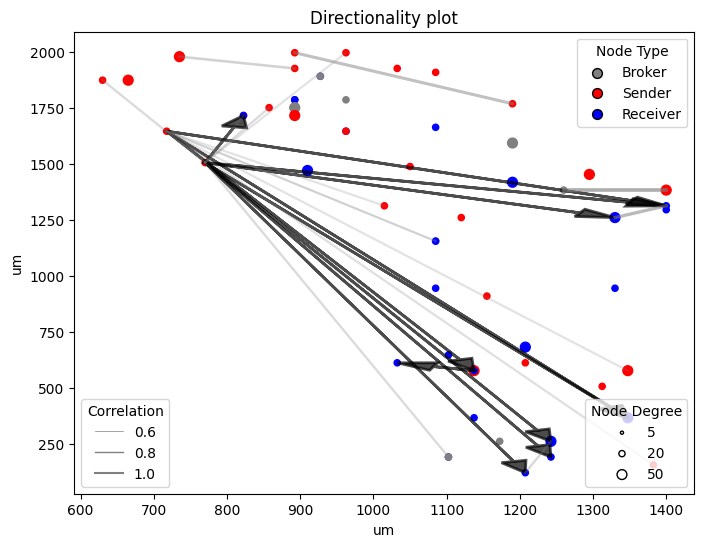

In [41]:
sttc_neuron_plotter_3(sd, colors, 0.4)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import FancyArrow

def sttc_neuron_plotter_3(inp_sd, upd_node_info, thresh):
    neuron_x = []
    neuron_y = []
    neuron_amp = []

    for neuron in inp_sd.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
        neuron_amp.append(np.mean(neuron['amplitudes']))

    neuron_amp = [closest_value(num) for num in neuron_amp]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(neuron_x, neuron_y, s=neuron_amp, c=upd_node_info)

    threshold = thresh
    sttc = inp_sd.spike_time_tilings()

    for i in range(sttc.shape[0]):
        for j in range(sttc.shape[1]):
            if i <= j:
                continue
            if sttc[i, j] < threshold:
                continue
            if upd_node_info[i] == 'blue' and upd_node_info[j] == 'red':
                ix, iy = inp_sd.neuron_data[0][i]['position']
                jx, jy = inp_sd.neuron_data[0][j]['position']
                linewidth = 2.0  # Set a thicker linewidth
                arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=15,
                                   linewidth=linewidth, color='black', alpha=0.7, edgecolor='black', facecolor='black')
                ax.add_patch(arrow)
            else:
                ix, iy = inp_sd.neuron_data[0][i]['position']
                jx, jy = inp_sd.neuron_data[0][j]['position']
                linewidth = 1.5 + 2 * (sttc[i, j] - threshold)
                opacity = 0.2 + 0.8 * (sttc[i, j] - threshold)
                ax.plot([ix, jx], [iy, jy], linewidth=linewidth, color='grey', alpha=opacity)

    ax.set_xlabel('um')
    ax.set_ylabel('um')
    ax.set_title("Directionality plot")  # Adding the title

    node_degree_legend_elements = [
        ax.scatter([], [], s=5, marker='o', edgecolor='black', facecolor='none', label='5'),
        ax.scatter([], [], s=20, marker='o', edgecolor='black', facecolor='none', label='20'),
        ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='none', label='50')
    ]

    node_type_legend_elements = [
        ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
        ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
        ax.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]

    node_degree_legend = ax.legend(handles=node_degree_legend_elements, title='Node Degree', loc='lower right')
    ax.add_artist(node_degree_legend)

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
        plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    ]

    correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
    ax.add_artist(correlation_legend)

    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')

    # Adding the "Direction" legend
    direction_legend = ax.legend(handles=[FancyArrow(0, 0, 1, 0, length_includes_head=True, head_width=15, linewidth=2, color='black')],
                                 labels=['Direction'], title='Legend', loc='upper right', bbox_to_anchor=(1.1, 1))
    ax.add_artist(direction_legend)

    plt.show()

/tmp/ipykernel_895217/1739770204.py:34: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow = FancyArrow(jx, jy, ix - jx, iy - jy, length_includes_head=True, head_width=15,


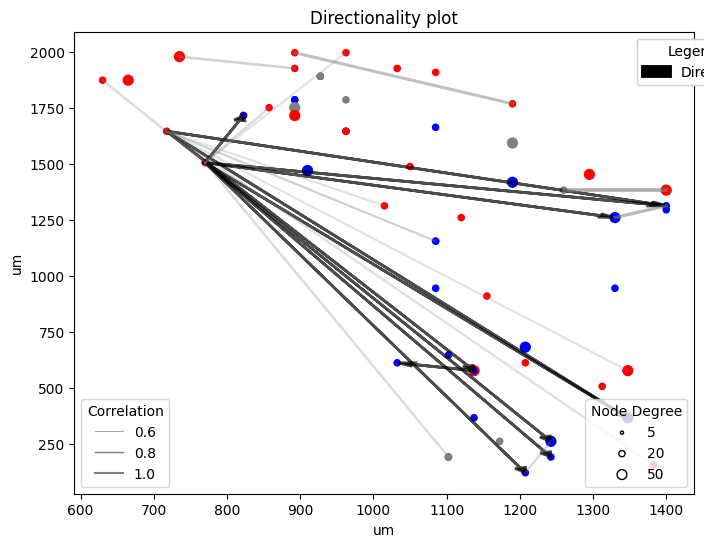

In [41]:
sttc_neuron_plotter_3(sd, colors, 0.4)